### Oppgave 1
Denne oppgaven baserer seg på data om trafikkulykker tilgjengelig fra SSB i Tabell:
“08329: Drepte eller skadde i trafikkulykker, etter alder, kjønn, skadegrad, trafikantgruppe og
ulykkestype 1999M01 - 2023M08”
En jobb som henter ut informasjon fra SSB finnes i git-repoet. Dere kan velge om dere vil
løse oppgavene i Python eller i R - eller en blanding! Hvis du vil bruke R må du først skrive
datasettet til en fil - for eksempel csv eller parquet. Det finnes også et ggplot-basert
visualiseringsbibliotek til Python, kan være verdt å prøve:
https://realpython.com/ggplot-python/

In [1]:
import os
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_bar, ggtitle, theme, facet_wrap, labs
from pathlib import Path
from os import listdir
# Fetching the df from ssb_trafikkulykker
%store -r df
df
# Endrer navnet på siste kolonne for oversikten sin skyld. 
# Bruker inplace for å oppdatere dataframe-en direkte uten å lagre den i dataframe på nytt.
df.rename(columns={"08329: Drepte eller skadde i trafikkulykker,": "Drepte eller skadde i trafikkulykker"}, inplace =True)
df

,skadegrad,trafikantgruppe,ulykkestype,måned,statistikkvariabel,Drepte eller skadde i trafikkulykker
0,Drept,Bilførere,A. Påkjøring bakfra,1999M01,Personer drept eller skadd,0
1,Drept,Bilførere,A. Påkjøring bakfra,1999M02,Personer drept eller skadd,0
2,Drept,Bilførere,A. Påkjøring bakfra,1999M03,Personer drept eller skadd,0
3,Drept,Bilførere,A. Påkjøring bakfra,1999M04,Personer drept eller skadd,0
4,Drept,Bilførere,A. Påkjøring bakfra,1999M05,Personer drept eller skadd,0
...,...,...,...,...,...,...
170491,Uoppgitt skadegrad,Andre trafikanter,L. Andre ulykker,2023M04,Personer drept eller skadd,0
170492,Uoppgitt skadegrad,Andre trafikanter,L. Andre ulykker,2023M05,Personer drept eller skadd,0
170493,Uoppgitt skadegrad,Andre trafikanter,L. Andre ulykker,2023M06,Personer drept eller skadd,0
170494,Uoppgitt skadegrad,Andre trafikanter,L. Andre ulykker,2023M07,Personer drept eller skadd,0


A) Formaterdatokolonnensomdatetime,brukf.eks.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
Sett dagen til 15. i hver måned.
Fjern også “\xa0” fra ulykkestype-kolonnen

In [2]:
# Lager ny kolonne "dato". Parser data fra eksisterende "måned" kolonne med oprinnelig format "%Y%M%m": f.eks. "1999M01". 
# Etter parsing blir dette XXXX-XX-01. Deretter bruker jeg timedelta fra pandas for å forskyve dagverdiene med 14 dager.
df['dato'] = pd.to_datetime(df['måned'], format='%YM%m') + pd.Timedelta(days=14)

# Fjerning av "xa0" fra ulykkestype-kolonnen
#df["ulykkestype"].unique()
# Her erstattes det strengen "/xao" med en tom string. 
# Bruker regex siden backslash / kan være en regular expression. Uten regex burde man skrevet "//xa0"
df['ulykkestype'] = df['ulykkestype'].str.replace('\xa0', '', regex=False)
df["ulykkestype"].unique()

array(['A. Påkjøring bakfra', 'B. Andre ulykker med samme kjøreretning',
       'C. Møting ved forbikjøring', 'D. Andre møteulykker',
       'E. Samme og motsatt kjøreretning med avsvinging',
       'F. Kryssende kjøreretning', 'G. Fotgjenger krysset kjørebanen',
       'H. Fotgjenger gikk langs eller oppholdt seg i kjørebanen',
       'I. Akende o.l.', 'J. Enslig kjøretøy utfor veien',
       'K. Enslig kjøretøy veltet i kjørebanen. Påkjøring av dyr, parkerte biler mv.',
       'L. Andre ulykker'], dtype=object)

B) Hva har skjedd med totalt antall drepte over tid? Lag et plott som viser utviklingen av
antall drepte for hvert år i datasettet fra første år med data i datasettet til nå.


In [3]:
# For å finne antall drepte per år trenger vi to nye kolonner: måned og år. Da bruker vi pandas time series
df["year"] = df["dato"].dt.year
df["month"] = df["dato"].dt.month

In [4]:
# Vi velger kun drepte fra "skadegrad" kolonnen
# Nå trenger vi å gruppere etter "year" og summere pr år. ear" 
# Legger til reset_index for å konvertere fra serie data til dataframe data. 
dfgr_b = df[(df["skadegrad"] == "Drept")].groupby("year")["Drepte eller skadde i trafikkulykker"].sum().reset_index(name="Drept i trafikkulykker")
dfgr_b


,year,Drept i trafikkulykker
0,1999,304
1,2000,341
2,2001,275
3,2002,310
4,2003,280
5,2004,257
6,2005,224
7,2006,242
8,2007,233
9,2008,255


C) Er det sesongmessig variasjon i skadetallene? Plott pr. måned og se om du ser et
mønster.


In [5]:
# Antar at skadetallene eksluderer drepte. Sjekker derfor hva er alternativene
df["skadegrad"].unique()

array(['Drept', 'Skadde i alt', 'Meget alvorlig skadd', 'Alvorlig skadd',
       'Lettere skadd', 'Uoppgitt skadegrad'], dtype=object)

<Axes: xlabel='month'>

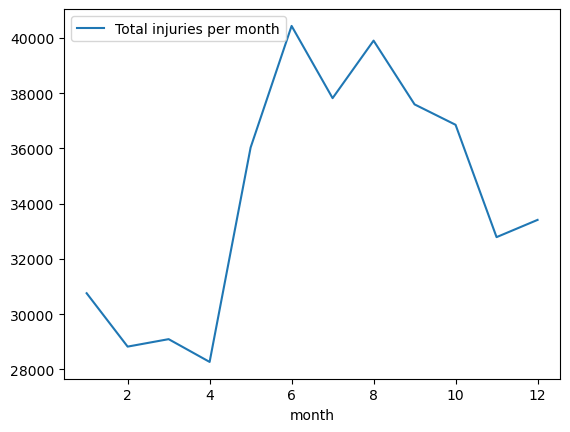

In [6]:
# Det fins 5 typer skader og "Drept" alternativet. Filtrerer den derfor bort
dfgr_c = df[(df["skadegrad"] != "Drept")].groupby("month")["Drepte eller skadde i trafikkulykker"].sum().reset_index(name="Total injuries per month")
dfgr_c

dfgr_c.plot("month", "Total injuries per month")

# Plottet pr måned viser de fleste skadene oppstår i perioden juni-august 


D) Lag et plott som viser andel av de drepte eller skadde med de ulike skadegradene
(inkl. drepte) for hvert år. Ikke ta med “Skadde i alt”.


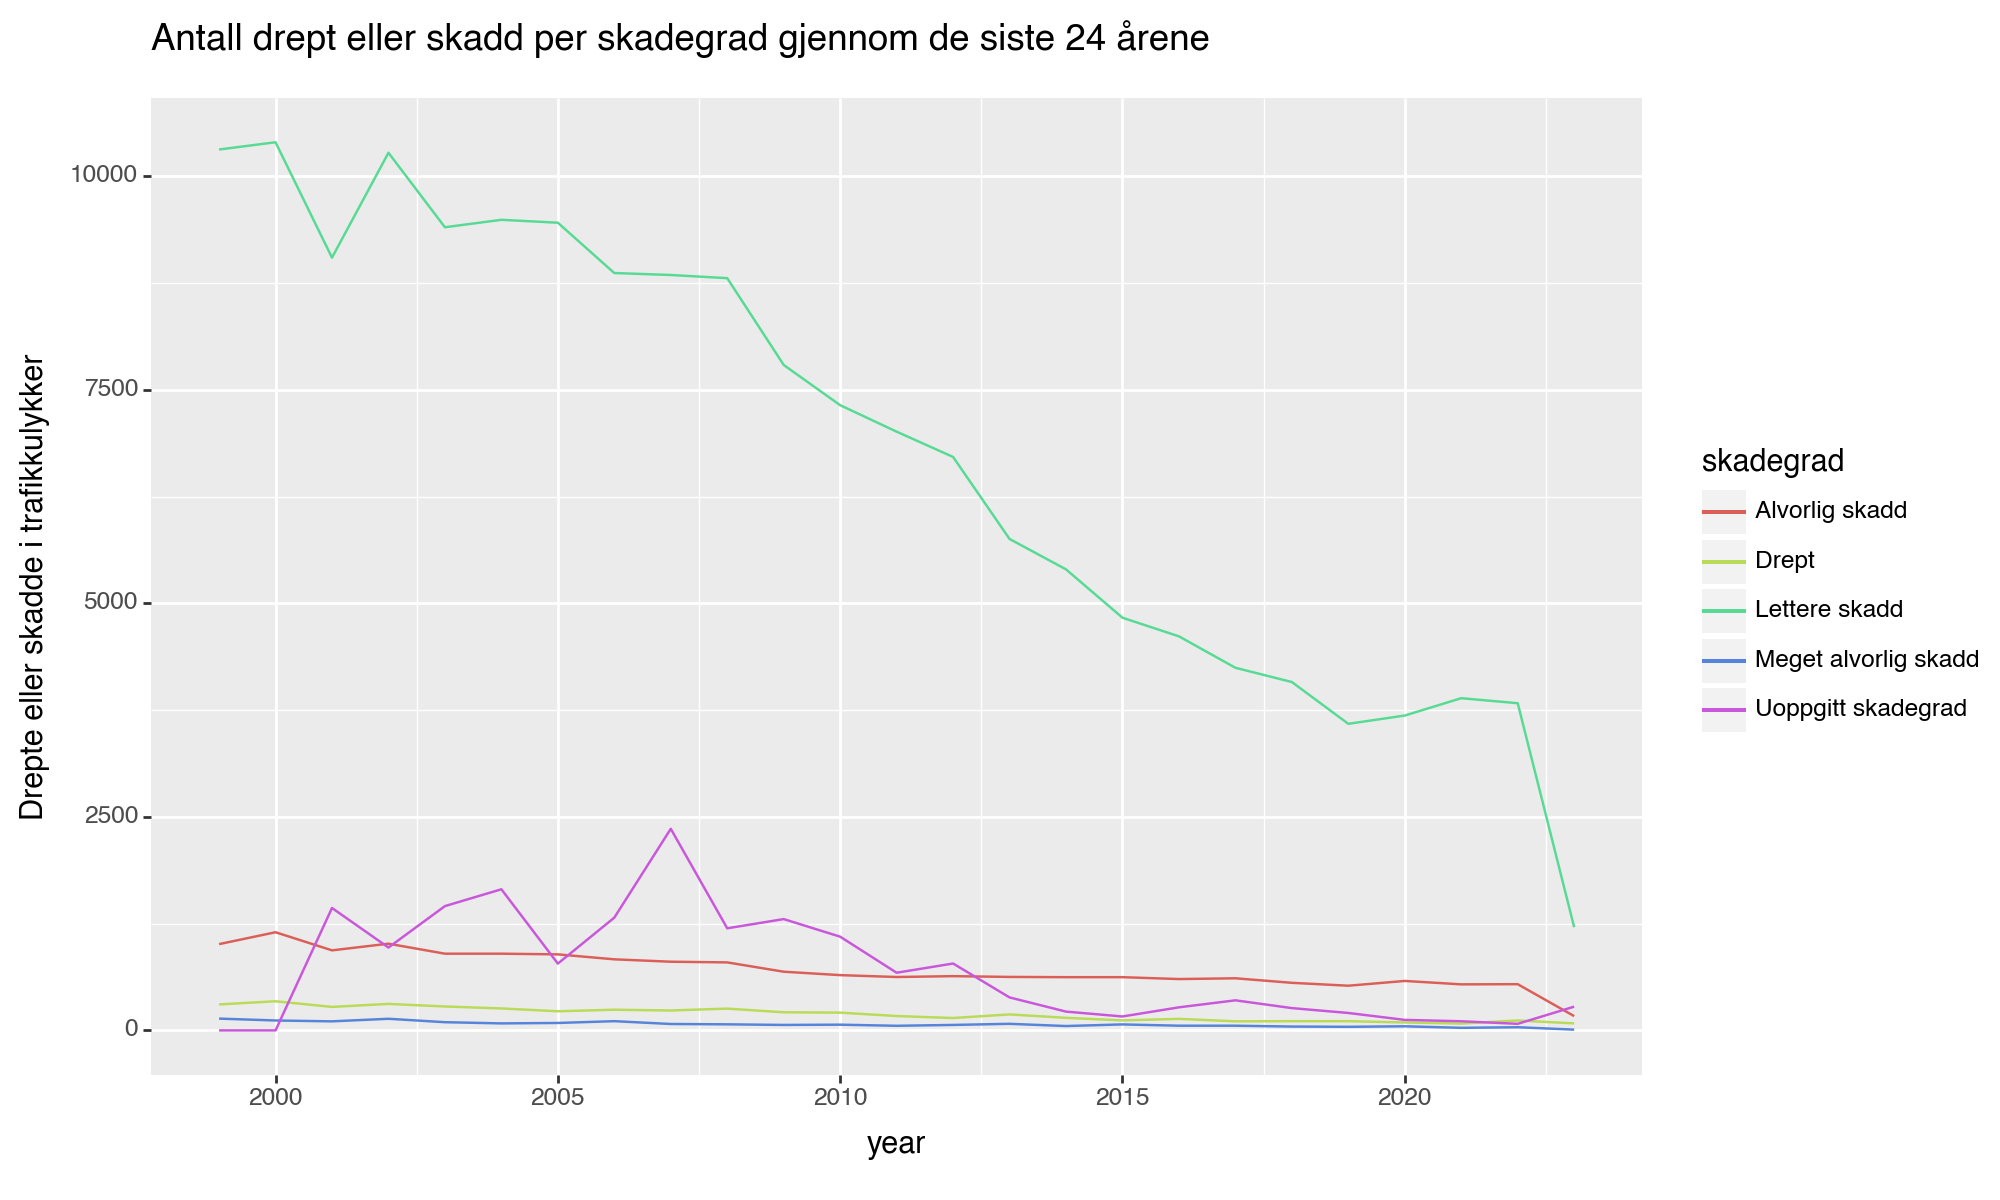

<Figure Size: (1000 x 600)>

In [7]:
dfgr_d = df[(df["skadegrad"] != 'Skadde i alt')].groupby(["year", "skadegrad"])["Drepte eller skadde i trafikkulykker"].sum().reset_index()

d_plot = (ggplot(dfgr_d, aes(x="year", y="Drepte eller skadde i trafikkulykker", color="skadegrad")) + 
          geom_line() + ggtitle("Antall drept eller skadd per skadegrad gjennom de siste 24 årene") +
            theme(figure_size=(10, 6)))
# Endret litt på størrelsen for å tydeligjøre plottet
d_plot


E) Lag et plott som viser utviklingen av de ulike typene møteulykker for hvert år (“Møting
ved forbikjøring” og “Andre møteulykker”). Det har blitt bygget mange midtdelere, så
disse bør det bli færre av.


In [8]:
df["ulykkestype"].unique()

array(['A. Påkjøring bakfra', 'B. Andre ulykker med samme kjøreretning',
       'C. Møting ved forbikjøring', 'D. Andre møteulykker',
       'E. Samme og motsatt kjøreretning med avsvinging',
       'F. Kryssende kjøreretning', 'G. Fotgjenger krysset kjørebanen',
       'H. Fotgjenger gikk langs eller oppholdt seg i kjørebanen',
       'I. Akende o.l.', 'J. Enslig kjøretøy utfor veien',
       'K. Enslig kjøretøy veltet i kjørebanen. Påkjøring av dyr, parkerte biler mv.',
       'L. Andre ulykker'], dtype=object)

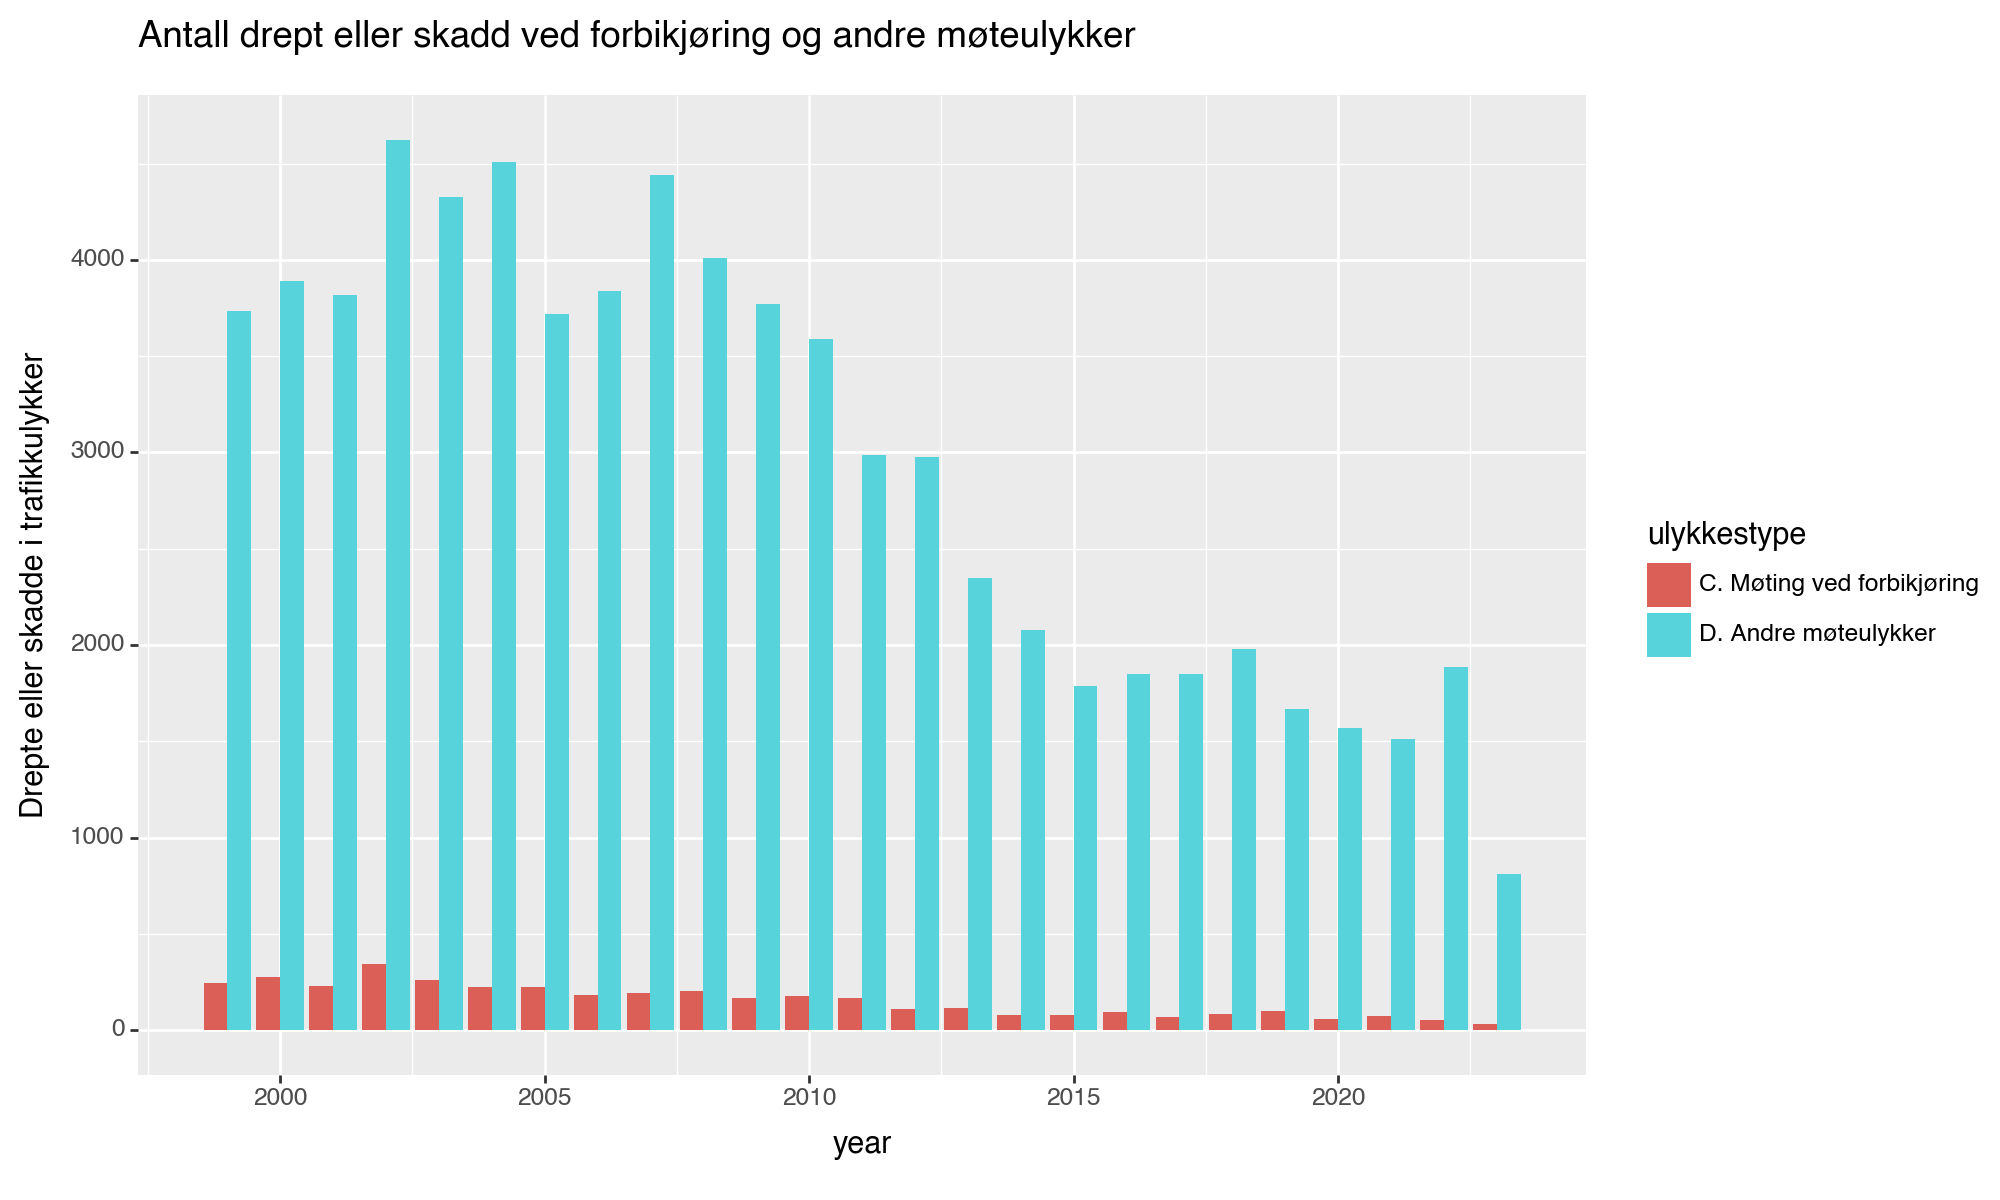

<Figure Size: (1000 x 600)>

In [9]:
dfgr_e = df[df["ulykkestype"].isin(["C. Møting ved forbikjøring", "D. Andre møteulykker"])].groupby(["year", "ulykkestype"])["Drepte eller skadde i trafikkulykker"].sum().reset_index()

# Da plotter vi i bar graf med position=dodge slik at antallet ulykker per ulykkestype 
# plasseres ved siden av hverandre for hvert år
e_plot = (ggplot(dfgr_e, aes(x="year", y="Drepte eller skadde i trafikkulykker", fill="ulykkestype")) + 
          geom_bar(stat="identity", position="dodge") + ggtitle("Antall drept eller skadd ved forbikjøring og andre møteulykker") +
            theme(figure_size=(10, 6)))
e_plot             

F) Vegtrafikkindeksen sier noe om hvordan trafikkmengden har utviklet seg over tid, og
er relevant informasjon for å forstå hvor mye tryggere det har blitt å være i trafikken.
https://www.vegvesen.no/globalassets/fag/trafikk/trafikkdata/vegtrafikkindeksen_2023-05.pdf
Tabell 8 viser kumulativ trafikkutvikling siden 2005. Bruk tabellen til å framskrive
antall i hver skadegrad fra 2005 år i datasettet til 2022. Inkluder denne informasjonen
i grafen fra deloppgave B.


In [10]:
# Leser inn trafikkindeks filen
df_indeks = pd.read_csv("trafikkindeks_fra_1995.csv")
df_indeks

,År,Trafikkutvikling fra 1995 i Prosent
0,1995,100.0
1,1996,102.8
2,1997,106.5
3,1998,109.9
4,1999,112.1
5,2000,114.0
6,2001,116.7
7,2002,120.3
8,2003,122.4
9,2004,124.9


In [11]:
# Sammenslåing av indeksen og dataframe fra deloppgave B
# Først endrer vi kolonnenavnet fra "år" til "year" for å gjøre det enklere å slå sammen
df_indeks.rename(columns={"År": "year"}, inplace =True)
dfgr_d2 =dfgr_d
dfgr_b2 = dfgr_b

In [12]:
# Indeks framen inneholder data fra 1995 mens datasettet inneholder data fra 1999. Da sletter vi data for år 1995-1998.
# Datasettet inneholder data for 2023, dette kan vi også slette.

df_indeks = df_indeks[df_indeks["year"] > 2004] 

# Da slette vi år 2023 og fjerner data fra 1995 til og med 2004.

dfgr_b2 = dfgr_b2[dfgr_b2["year"] != 2023]
dfgr_d2 = dfgr_d2[dfgr_d2["year"] != 2023]
# Nå er intervallet 2005-2022 i begge dataframes og indeks tabellen


In [13]:
# Slår sammen begge frames

df_sammen_temp = pd.merge(dfgr_b2, df_indeks, on="year")
df_sammen = pd.merge(dfgr_d2, df_sammen_temp, on="year")
df_sammen

,year,skadegrad,Drepte eller skadde i trafikkulykker,Drept i trafikkulykker,Trafikkutvikling fra 1995 i Prosent
0,2005,Alvorlig skadd,890,224,128.1
1,2005,Drept,224,224,128.1
2,2005,Lettere skadd,9455,224,128.1
3,2005,Meget alvorlig skadd,87,224,128.1
4,2005,Uoppgitt skadegrad,782,224,128.1
...,...,...,...,...,...
85,2022,Alvorlig skadd,541,116,154.2
86,2022,Drept,116,116,154.2
87,2022,Lettere skadd,3830,116,154.2
88,2022,Meget alvorlig skadd,37,116,154.2


In [14]:
# Data for 2005 begynner fra 128%. Dette trenger vi å normalisere for. 
# Lagrer 128 som en temp og så deler på den for å begynne graderingen på nytt fra 100%
# Konverterer til integer for å fjerne desimalene. Kunne også brukt .round() 
df_temp = df_sammen.loc[df_sammen["year"] == 2005, "Trafikkutvikling fra 1995 i Prosent"].iloc[0].astype(int)
df_sammen["Trafikkutvikling fra 1995 i Prosent"] = df_sammen["Trafikkutvikling fra 1995 i Prosent"].astype(int) / df_temp * 100
df_sammen

,year,skadegrad,Drepte eller skadde i trafikkulykker,Drept i trafikkulykker,Trafikkutvikling fra 1995 i Prosent
0,2005,Alvorlig skadd,890,224,100.0000
1,2005,Drept,224,224,100.0000
2,2005,Lettere skadd,9455,224,100.0000
3,2005,Meget alvorlig skadd,87,224,100.0000
4,2005,Uoppgitt skadegrad,782,224,100.0000
...,...,...,...,...,...
85,2022,Alvorlig skadd,541,116,120.3125
86,2022,Drept,116,116,120.3125
87,2022,Lettere skadd,3830,116,120.3125
88,2022,Meget alvorlig skadd,37,116,120.3125


In [15]:
# Lager ny kolonne med justert "framskrevet" antall skadd/dødsfall
df_sammen["Framskrevet antall skadd/døde"] = df_sammen["Drepte eller skadde i trafikkulykker"] * df_sammen["Trafikkutvikling fra 1995 i Prosent"] / 100
df_sammen


,year,skadegrad,Drepte eller skadde i trafikkulykker,Drept i trafikkulykker,Trafikkutvikling fra 1995 i Prosent,Framskrevet antall skadd/døde
0,2005,Alvorlig skadd,890,224,100.0000,890.000000
1,2005,Drept,224,224,100.0000,224.000000
2,2005,Lettere skadd,9455,224,100.0000,9455.000000
3,2005,Meget alvorlig skadd,87,224,100.0000,87.000000
4,2005,Uoppgitt skadegrad,782,224,100.0000,782.000000
...,...,...,...,...,...,...
85,2022,Alvorlig skadd,541,116,120.3125,650.890625
86,2022,Drept,116,116,120.3125,139.562500
87,2022,Lettere skadd,3830,116,120.3125,4607.968750
88,2022,Meget alvorlig skadd,37,116,120.3125,44.515625


In [22]:
# Grupperer
dfgr_sammen = df_sammen.groupby(["year", "skadegrad"])[["Drepte eller skadde i trafikkulykker", "Framskrevet antall skadd/døde", "Drept i trafikkulykker"]].sum().reset_index()
dfgr_sammen

,year,skadegrad,Drepte eller skadde i trafikkulykker,Framskrevet antall skadd/døde,Drept i trafikkulykker
0,2005,Alvorlig skadd,890,890.000000,224
1,2005,Drept,224,224.000000,224
2,2005,Lettere skadd,9455,9455.000000,224
3,2005,Meget alvorlig skadd,87,87.000000,224
4,2005,Uoppgitt skadegrad,782,782.000000,224
...,...,...,...,...,...
85,2022,Alvorlig skadd,541,650.890625,116
86,2022,Drept,116,139.562500,116
87,2022,Lettere skadd,3830,4607.968750,116
88,2022,Meget alvorlig skadd,37,44.515625,116


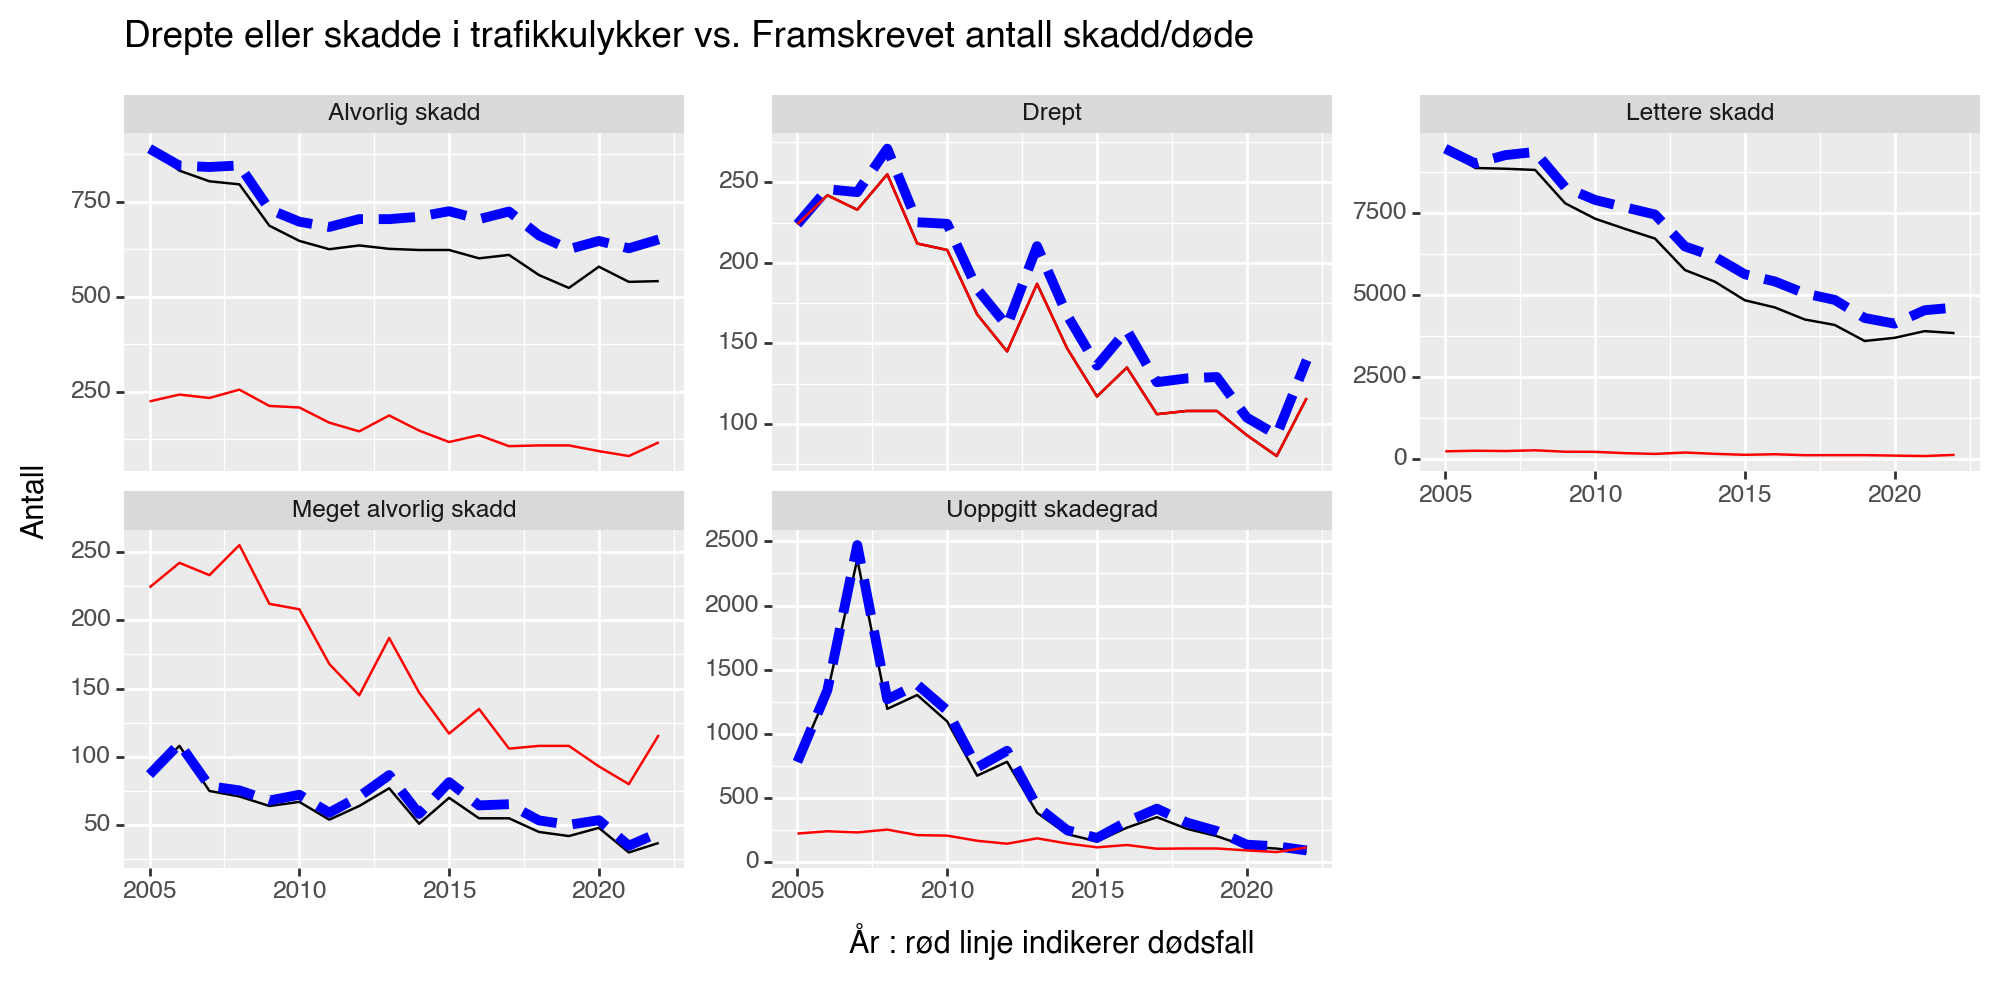

<Figure Size: (1000 x 500)>

In [27]:
# Visualisering
dfgr_sammen_plot = (ggplot(dfgr_sammen, aes(x="year")) + 
    geom_line(aes(y="Drepte eller skadde i trafikkulykker")) +
    geom_line(aes(y="Framskrevet antall skadd/døde"), color="blue", linetype='--', size=2) +
    geom_line(aes(y="Drept i trafikkulykker"), color="red") +
        facet_wrap('~skadegrad',scales="free_y") +
        theme(figure_size=(10, 5)) +
        labs(title="Drepte eller skadde i trafikkulykker vs. Framskrevet antall skadd/døde",
        x="År : rød linje indikerer dødsfall",
        y="Antall"))
dfgr_sammen_plot